C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


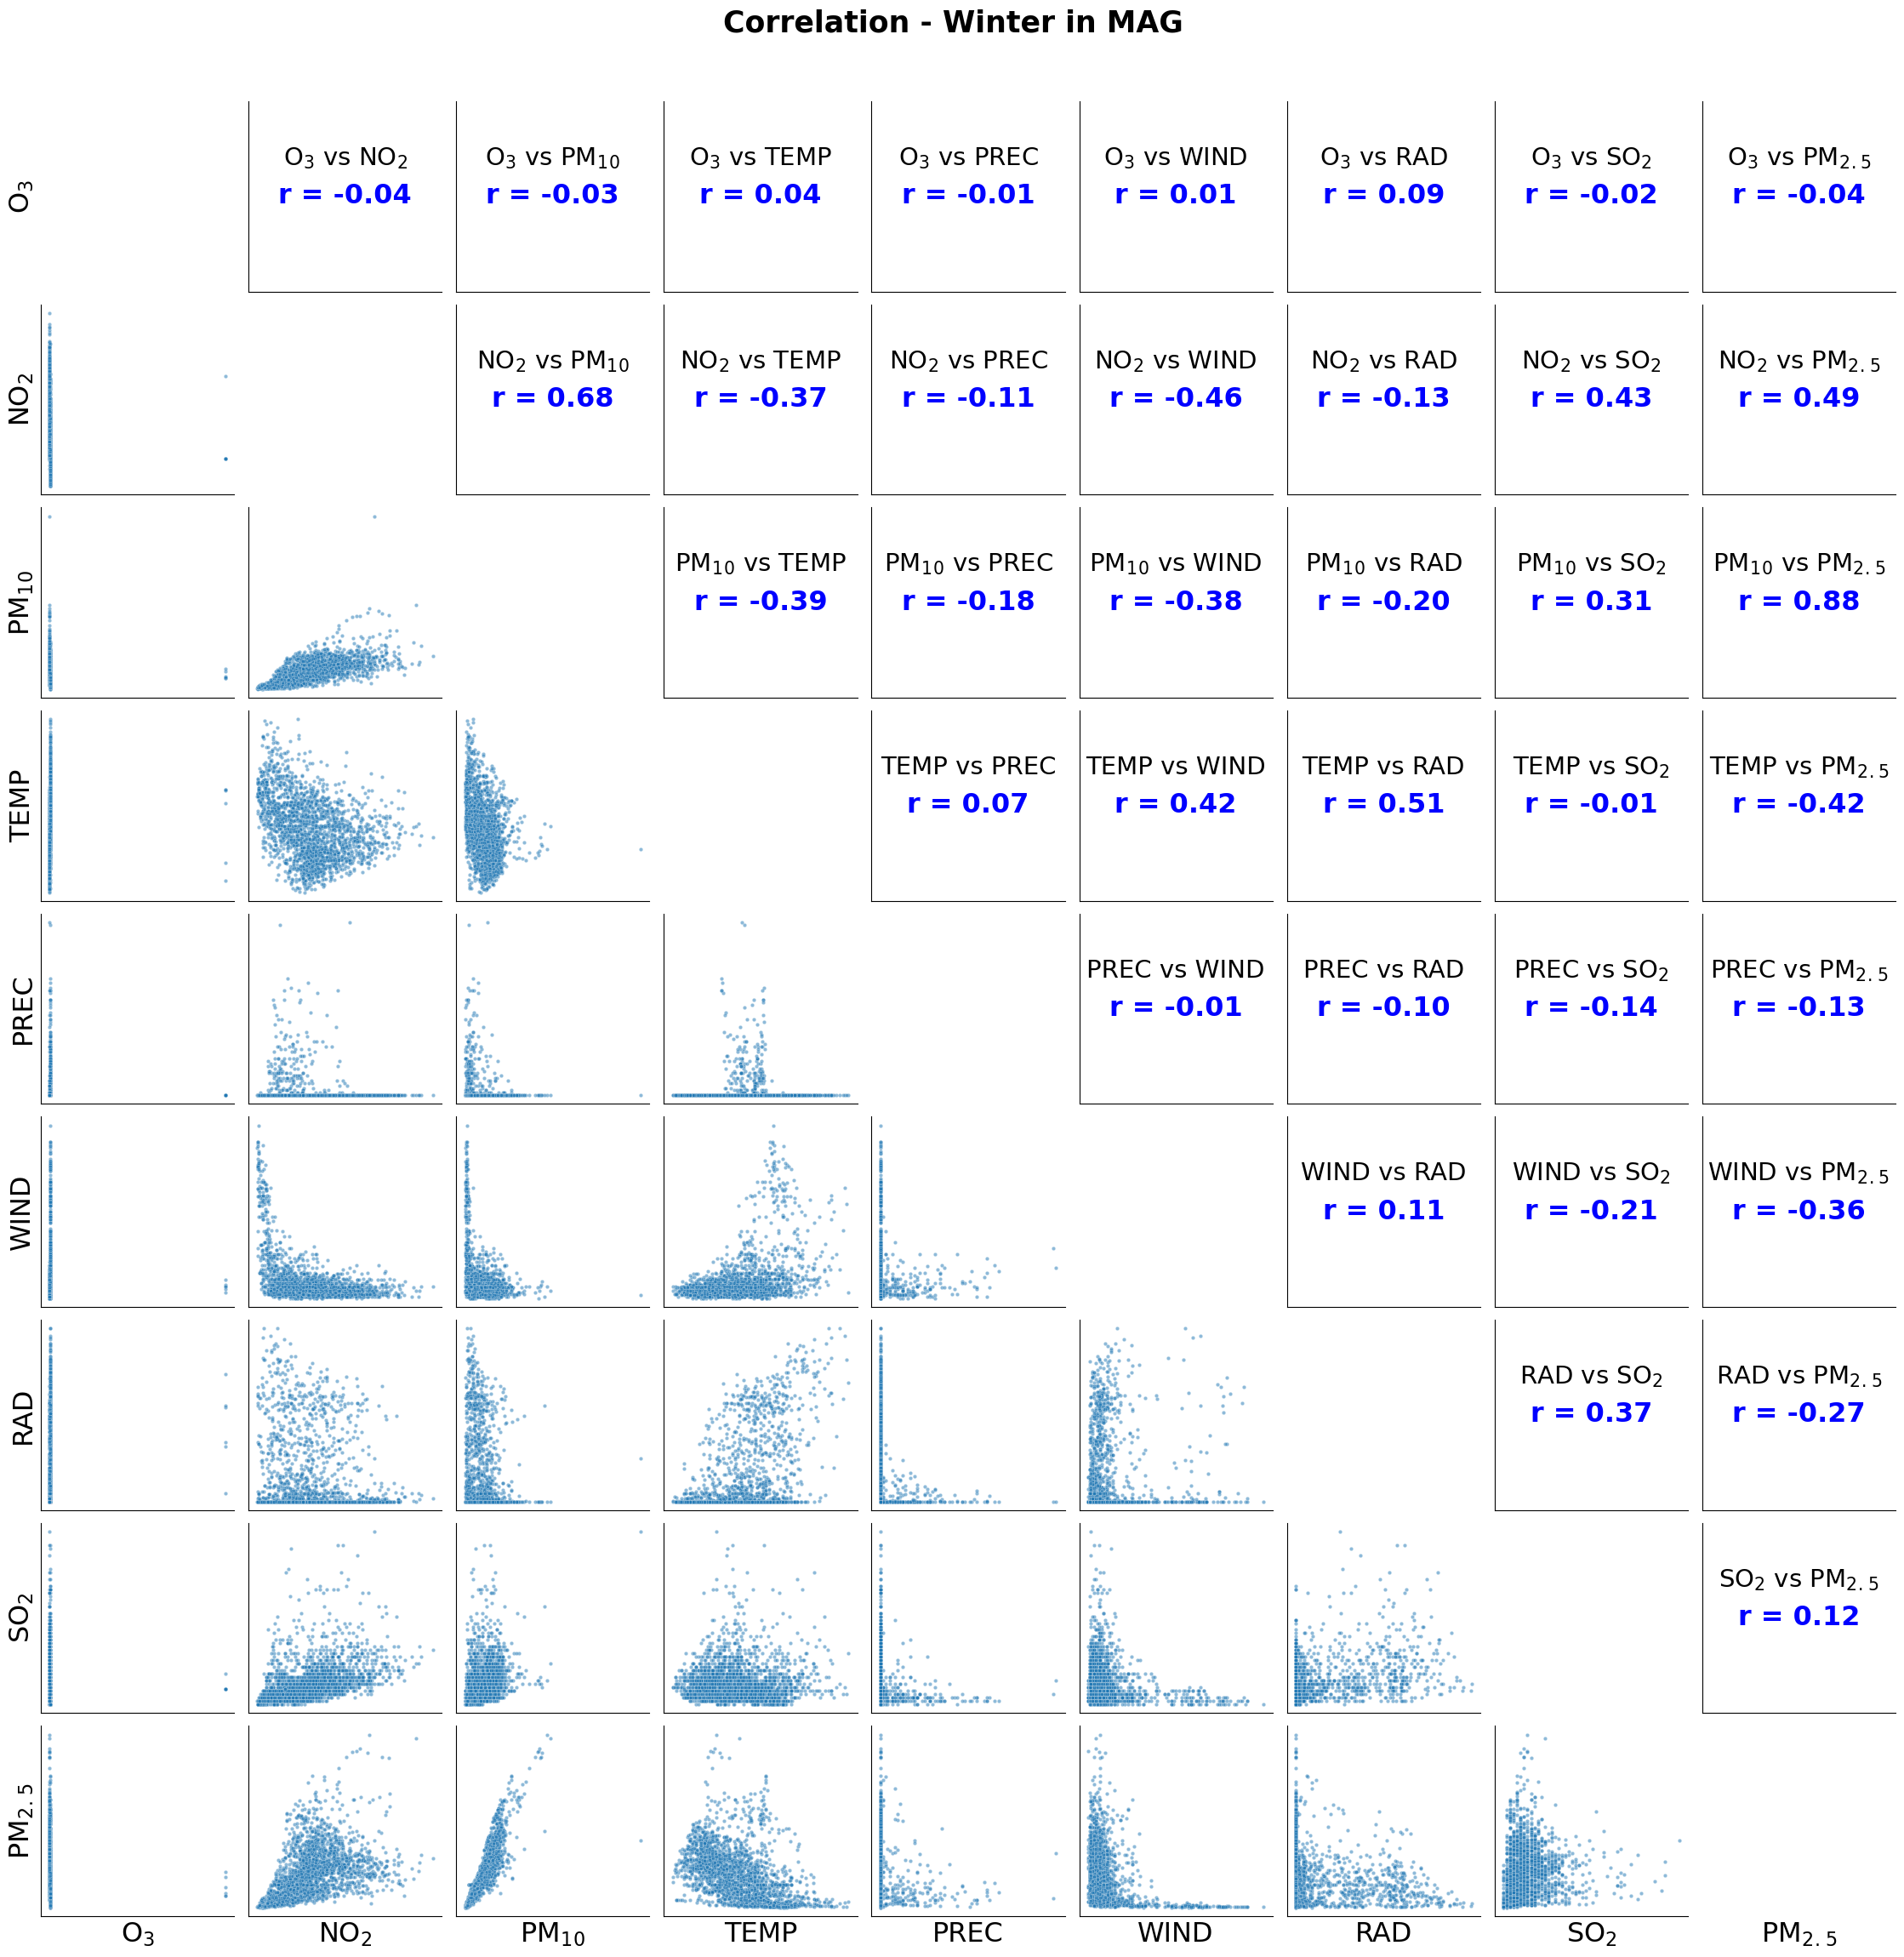

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


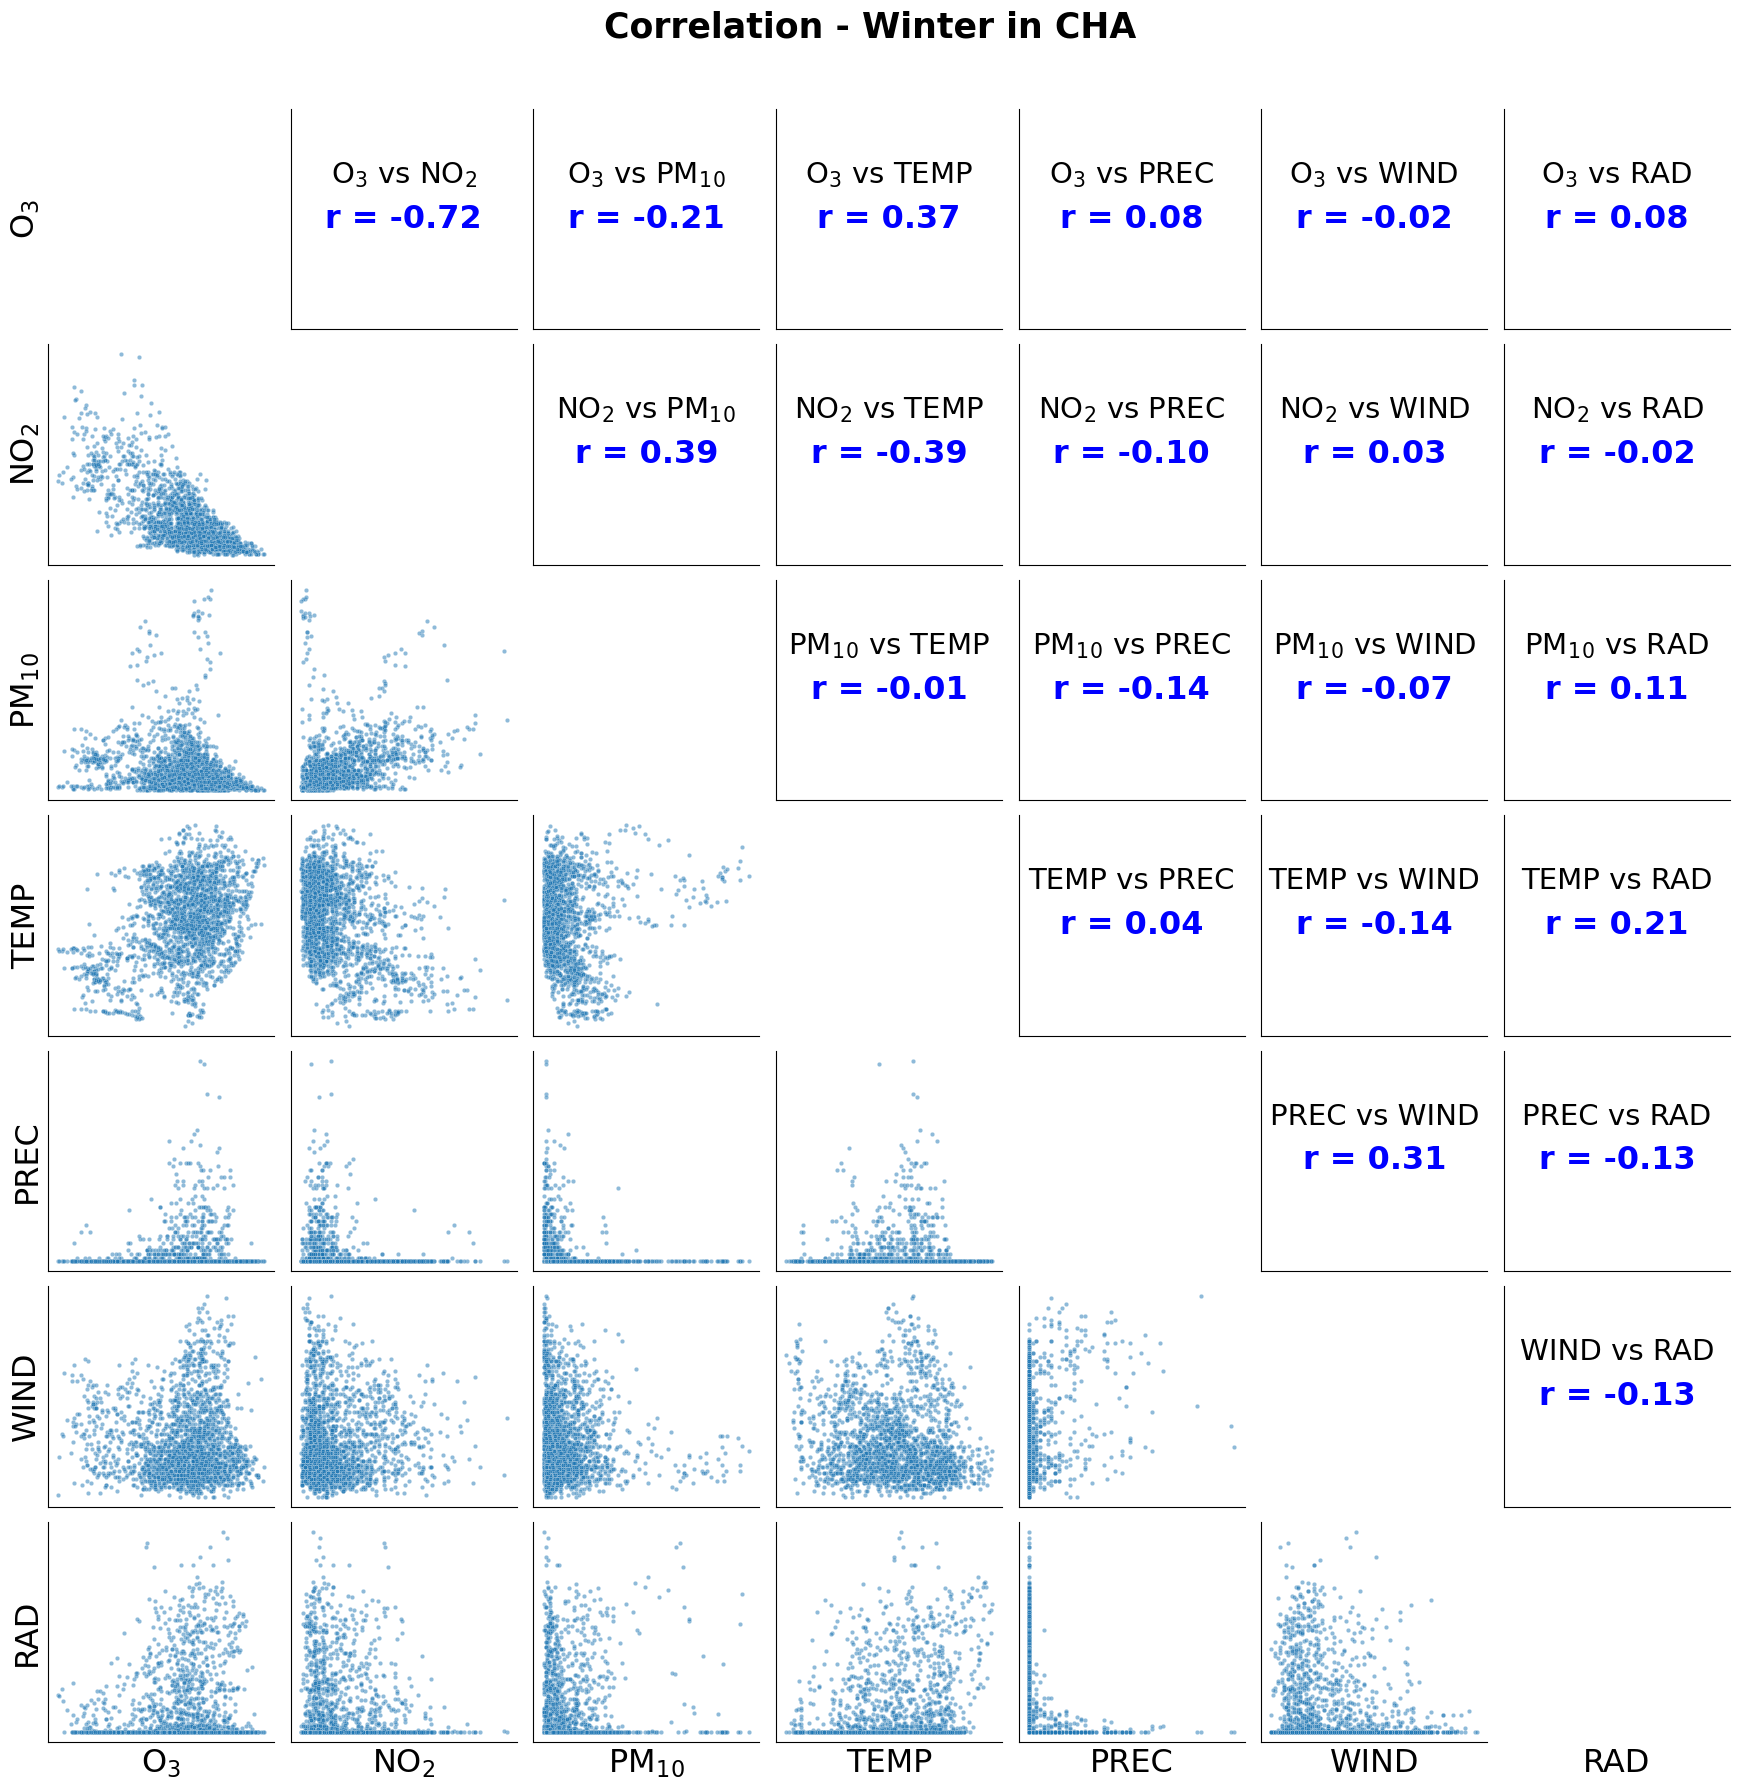

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


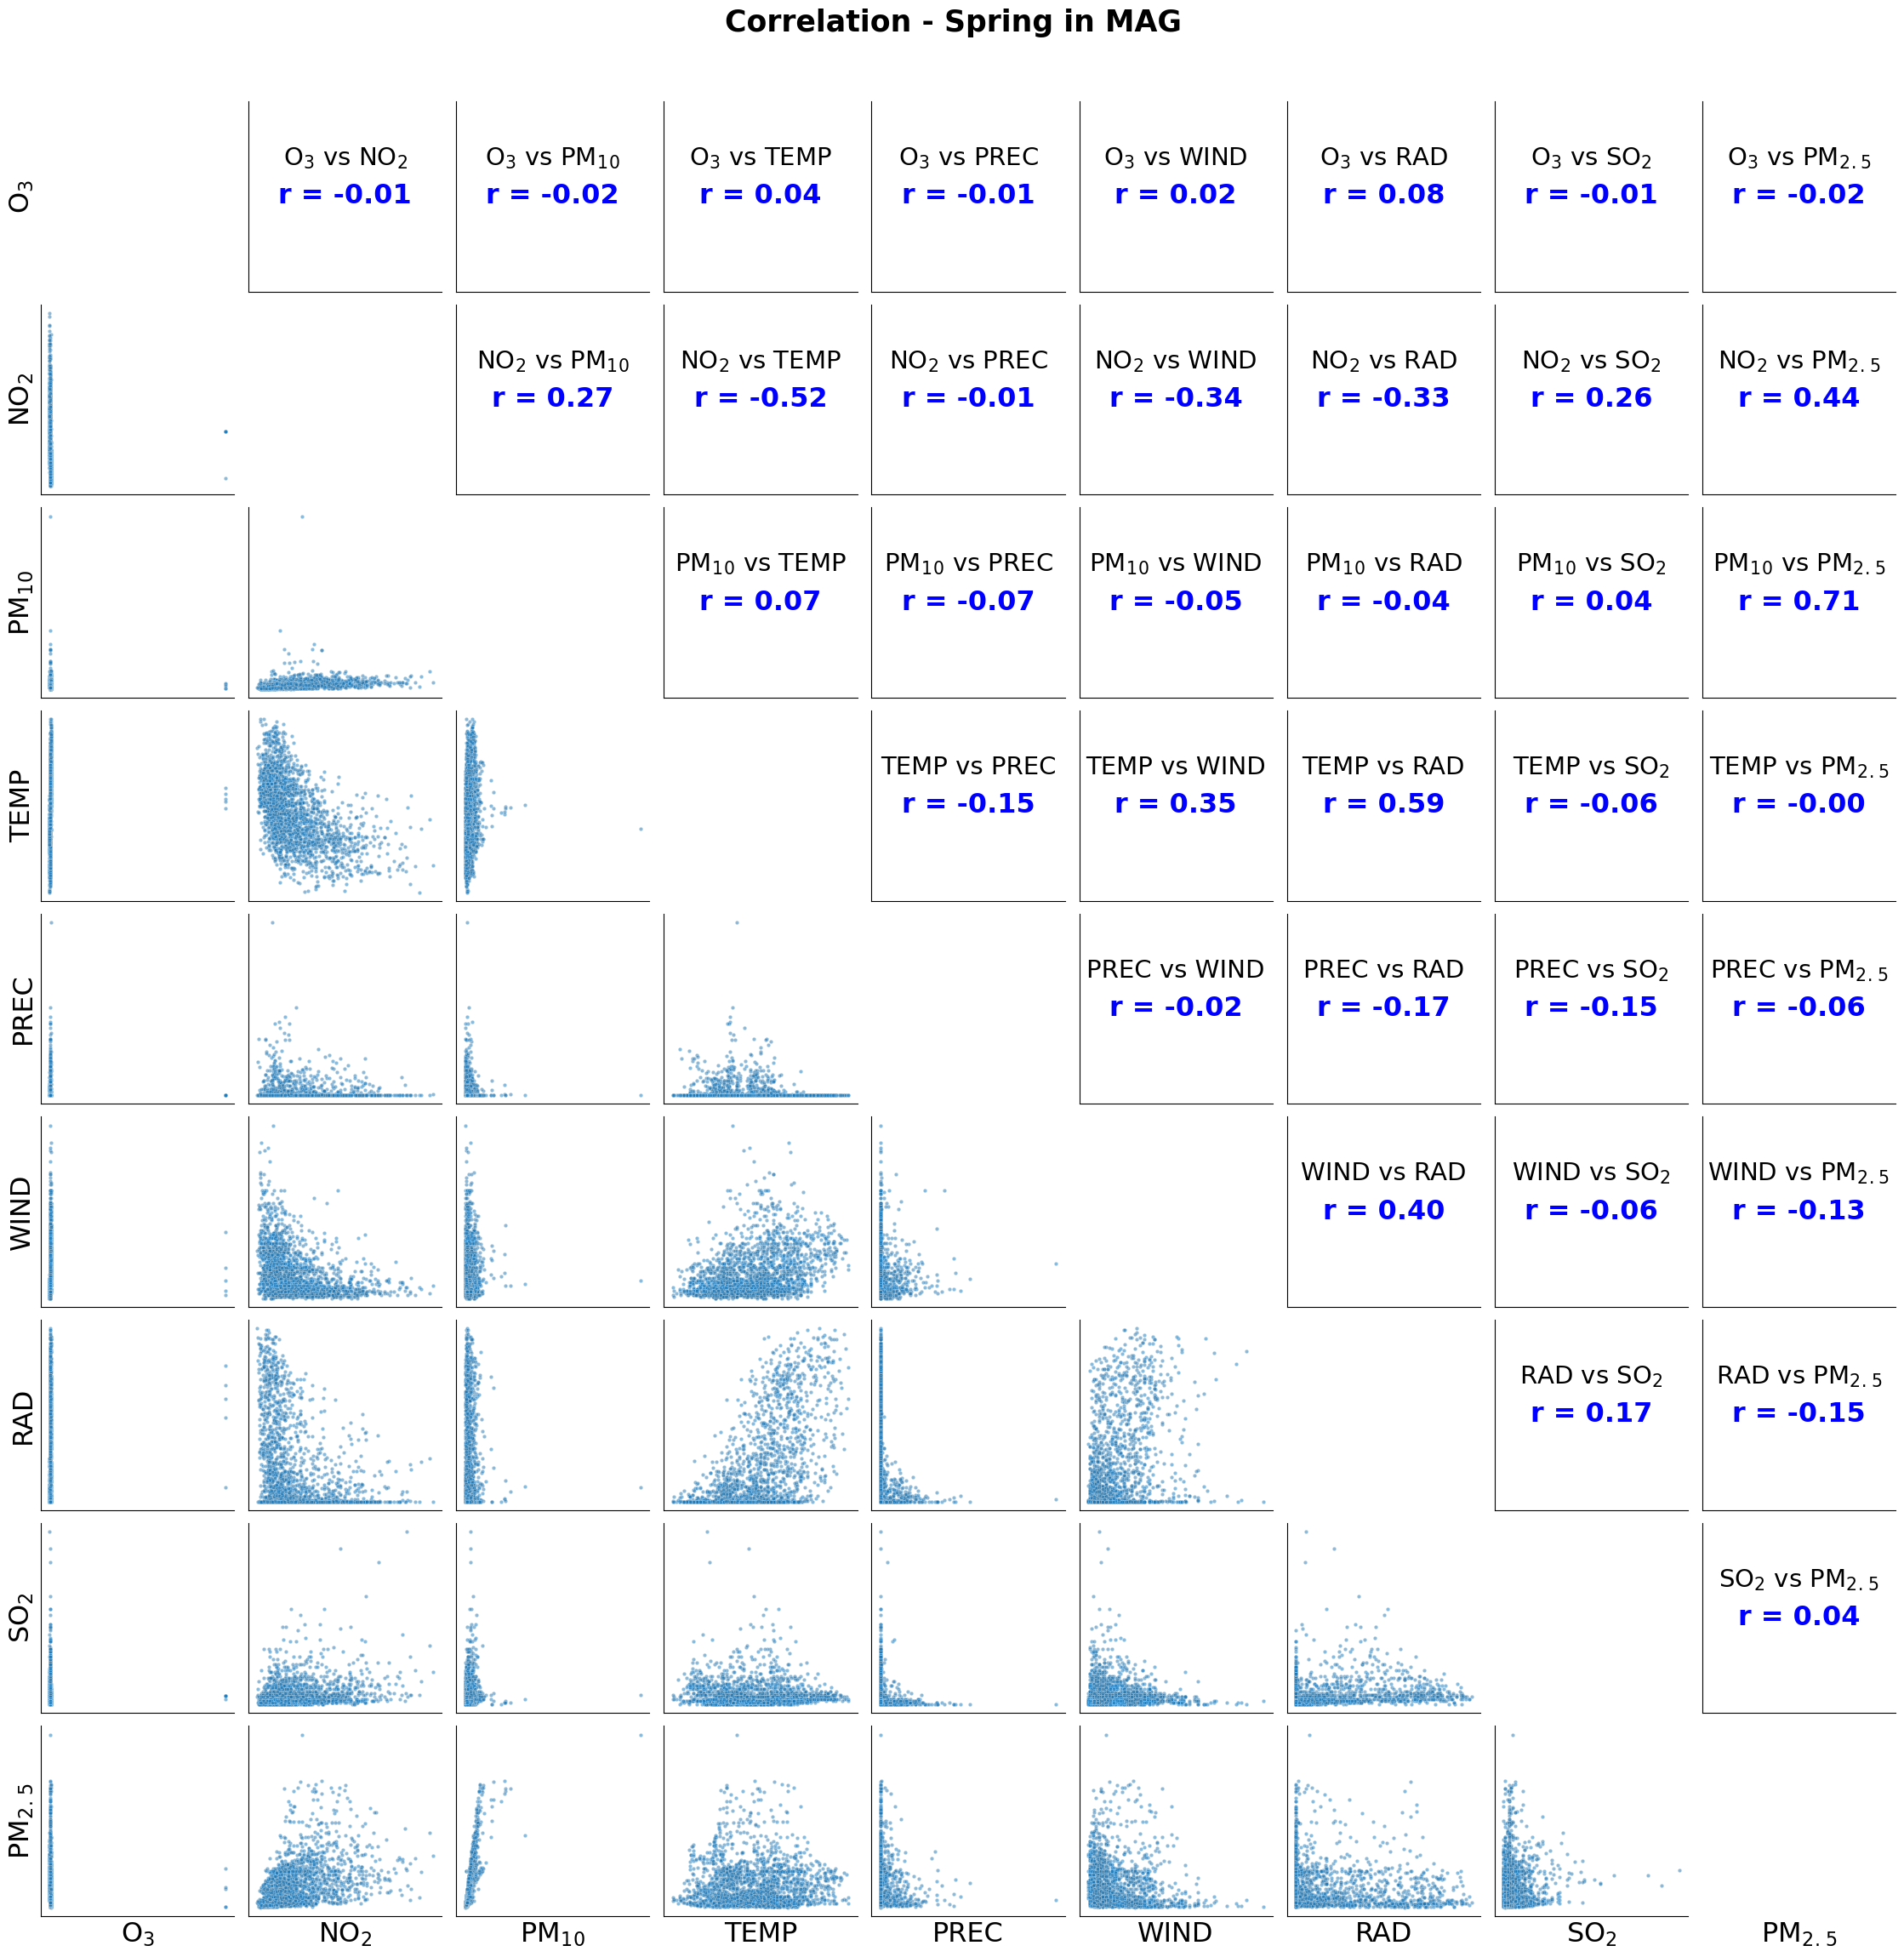

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


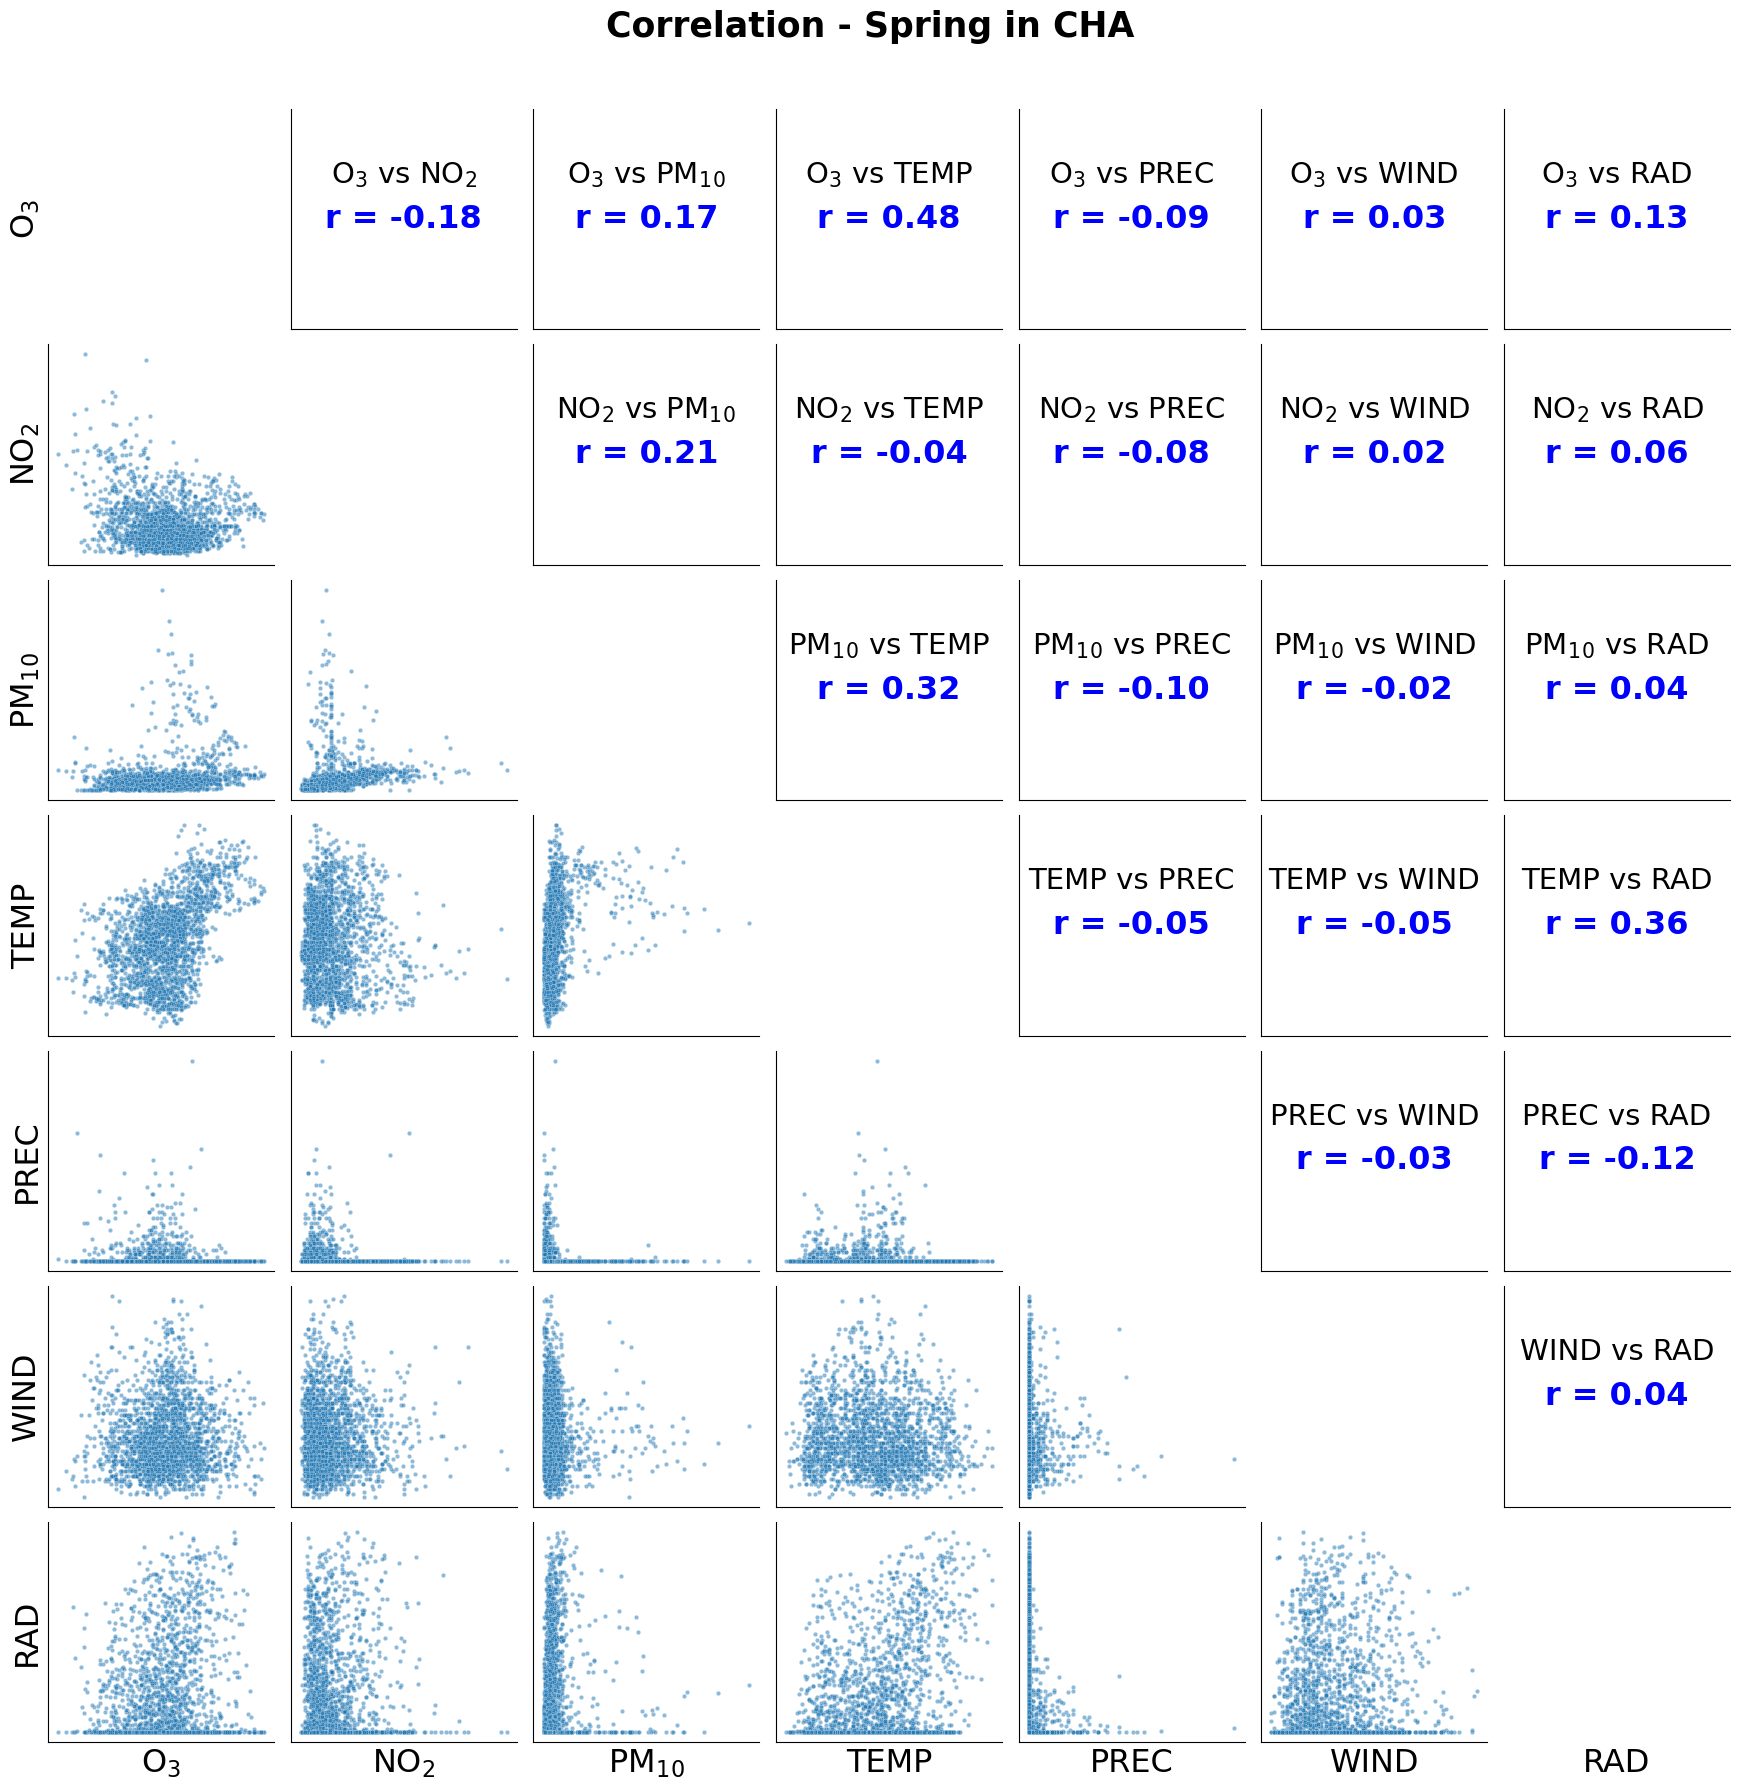

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


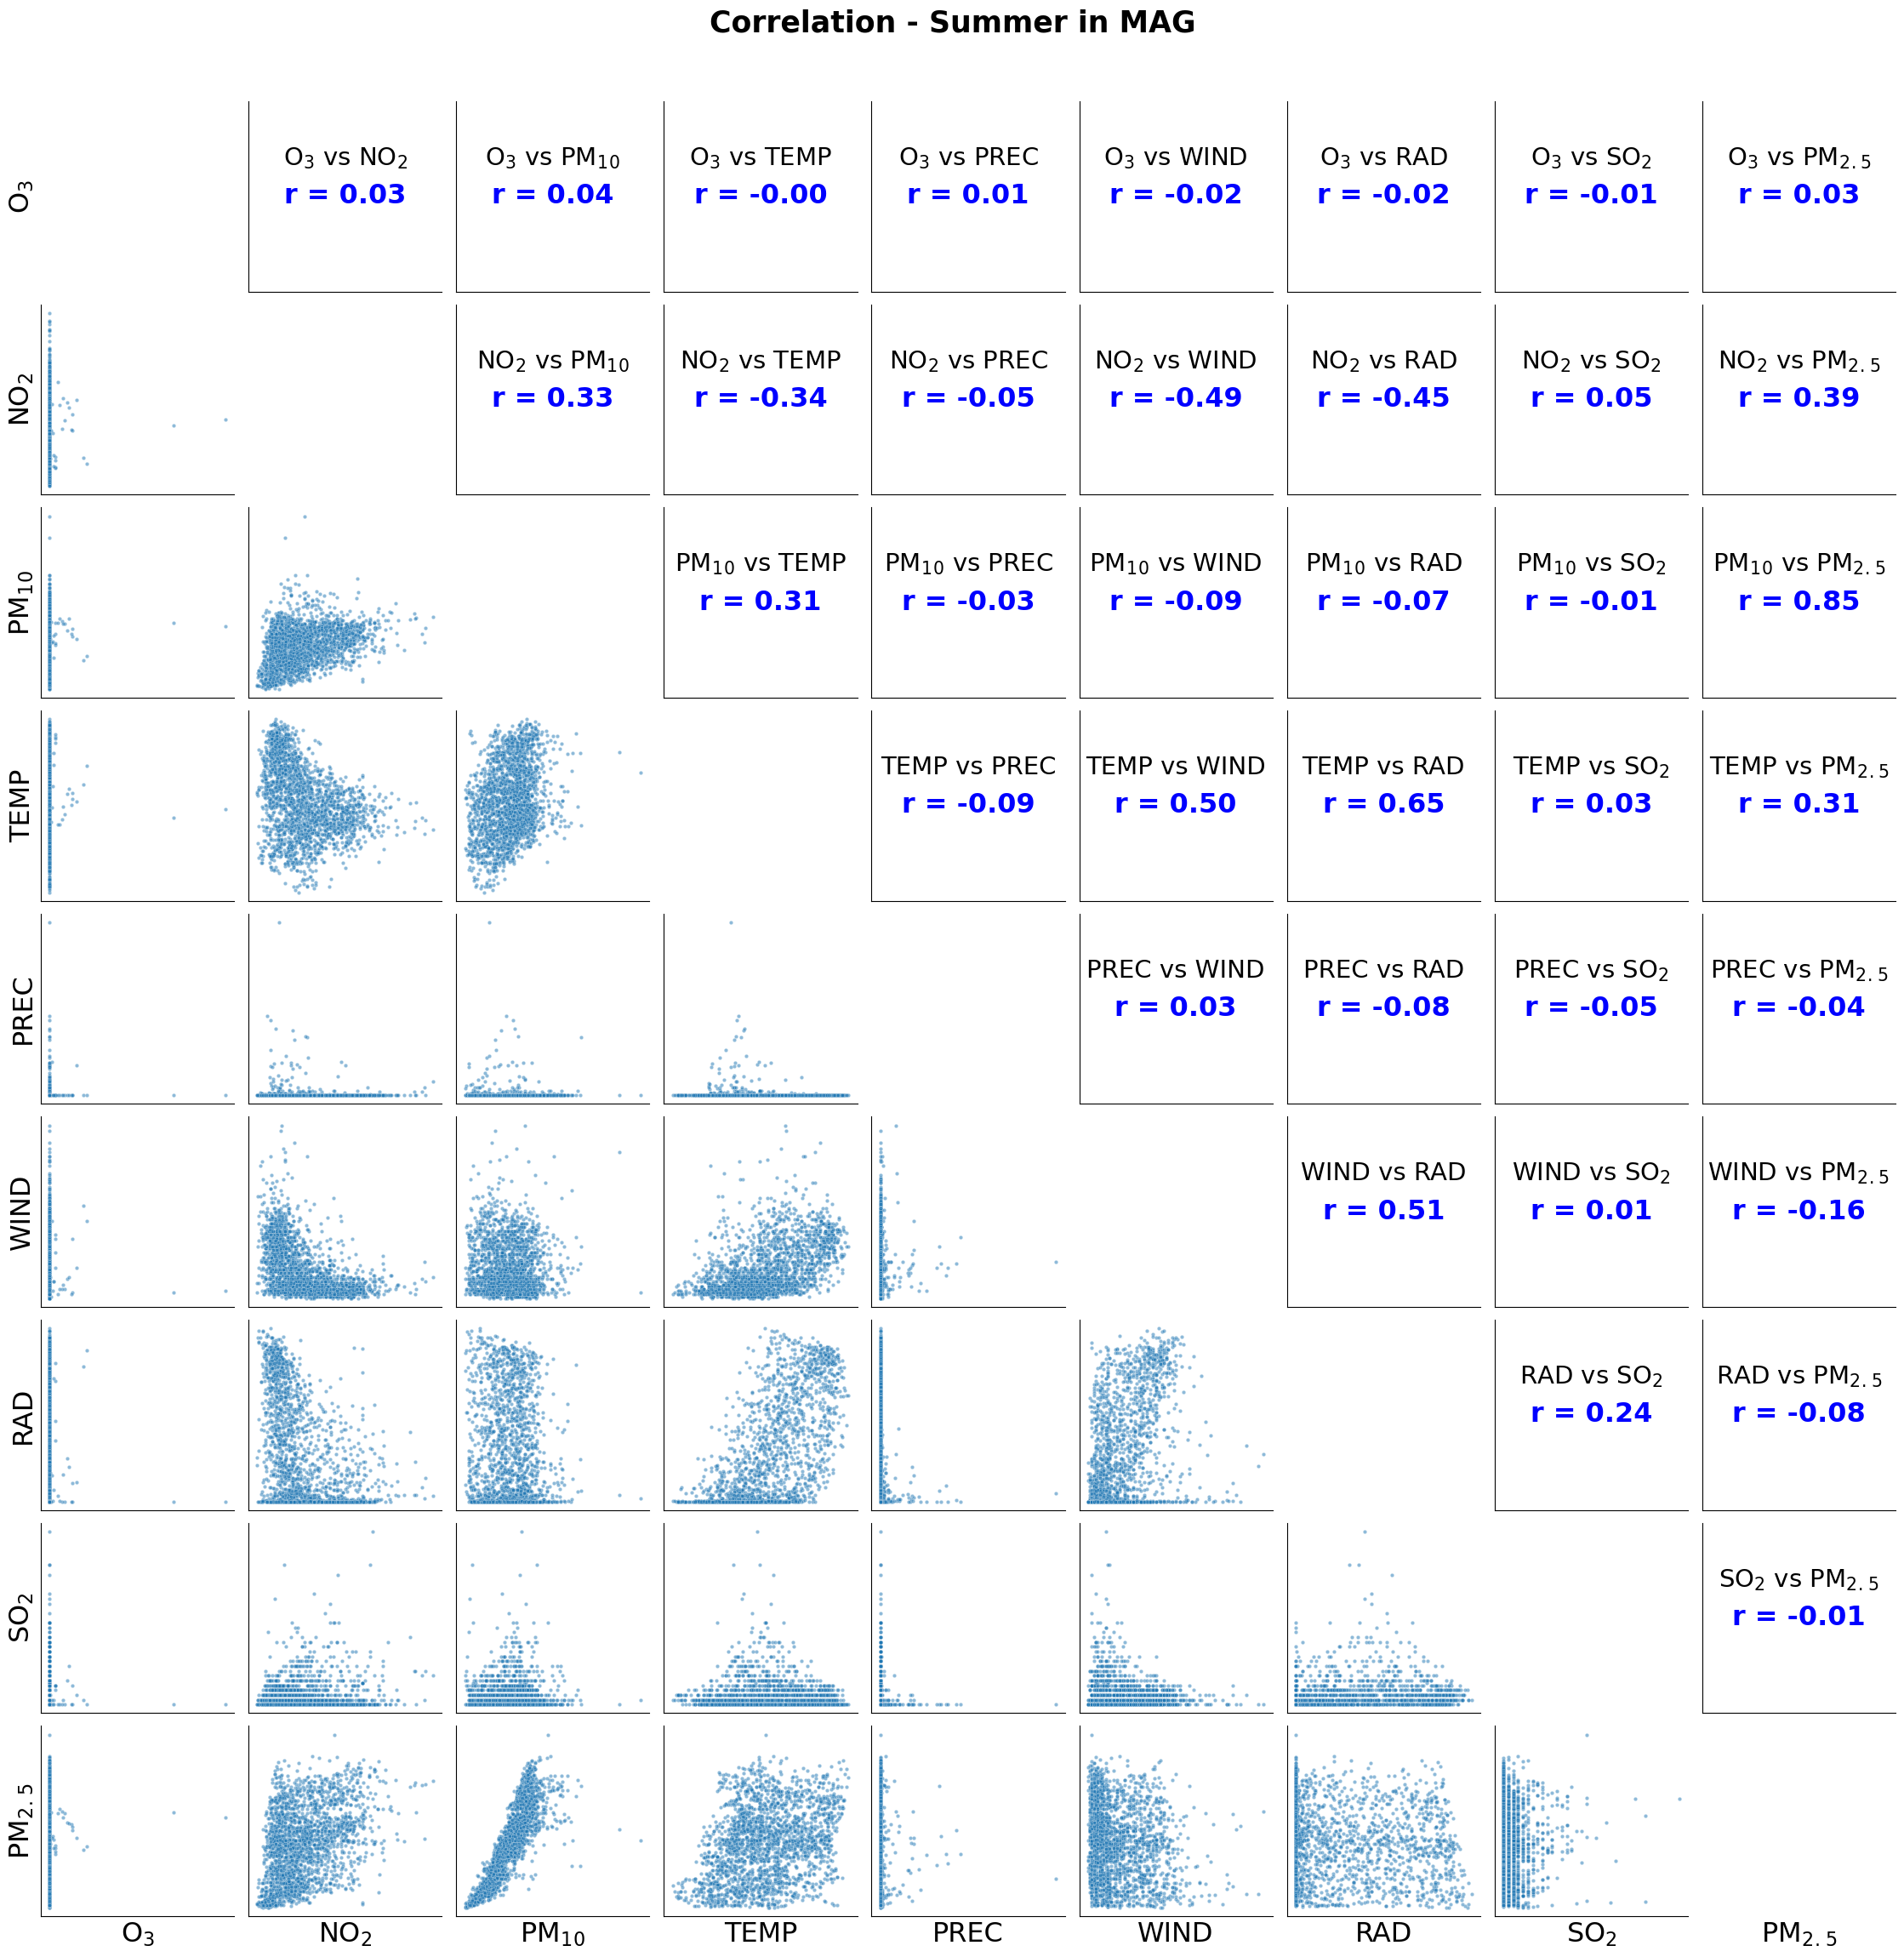

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


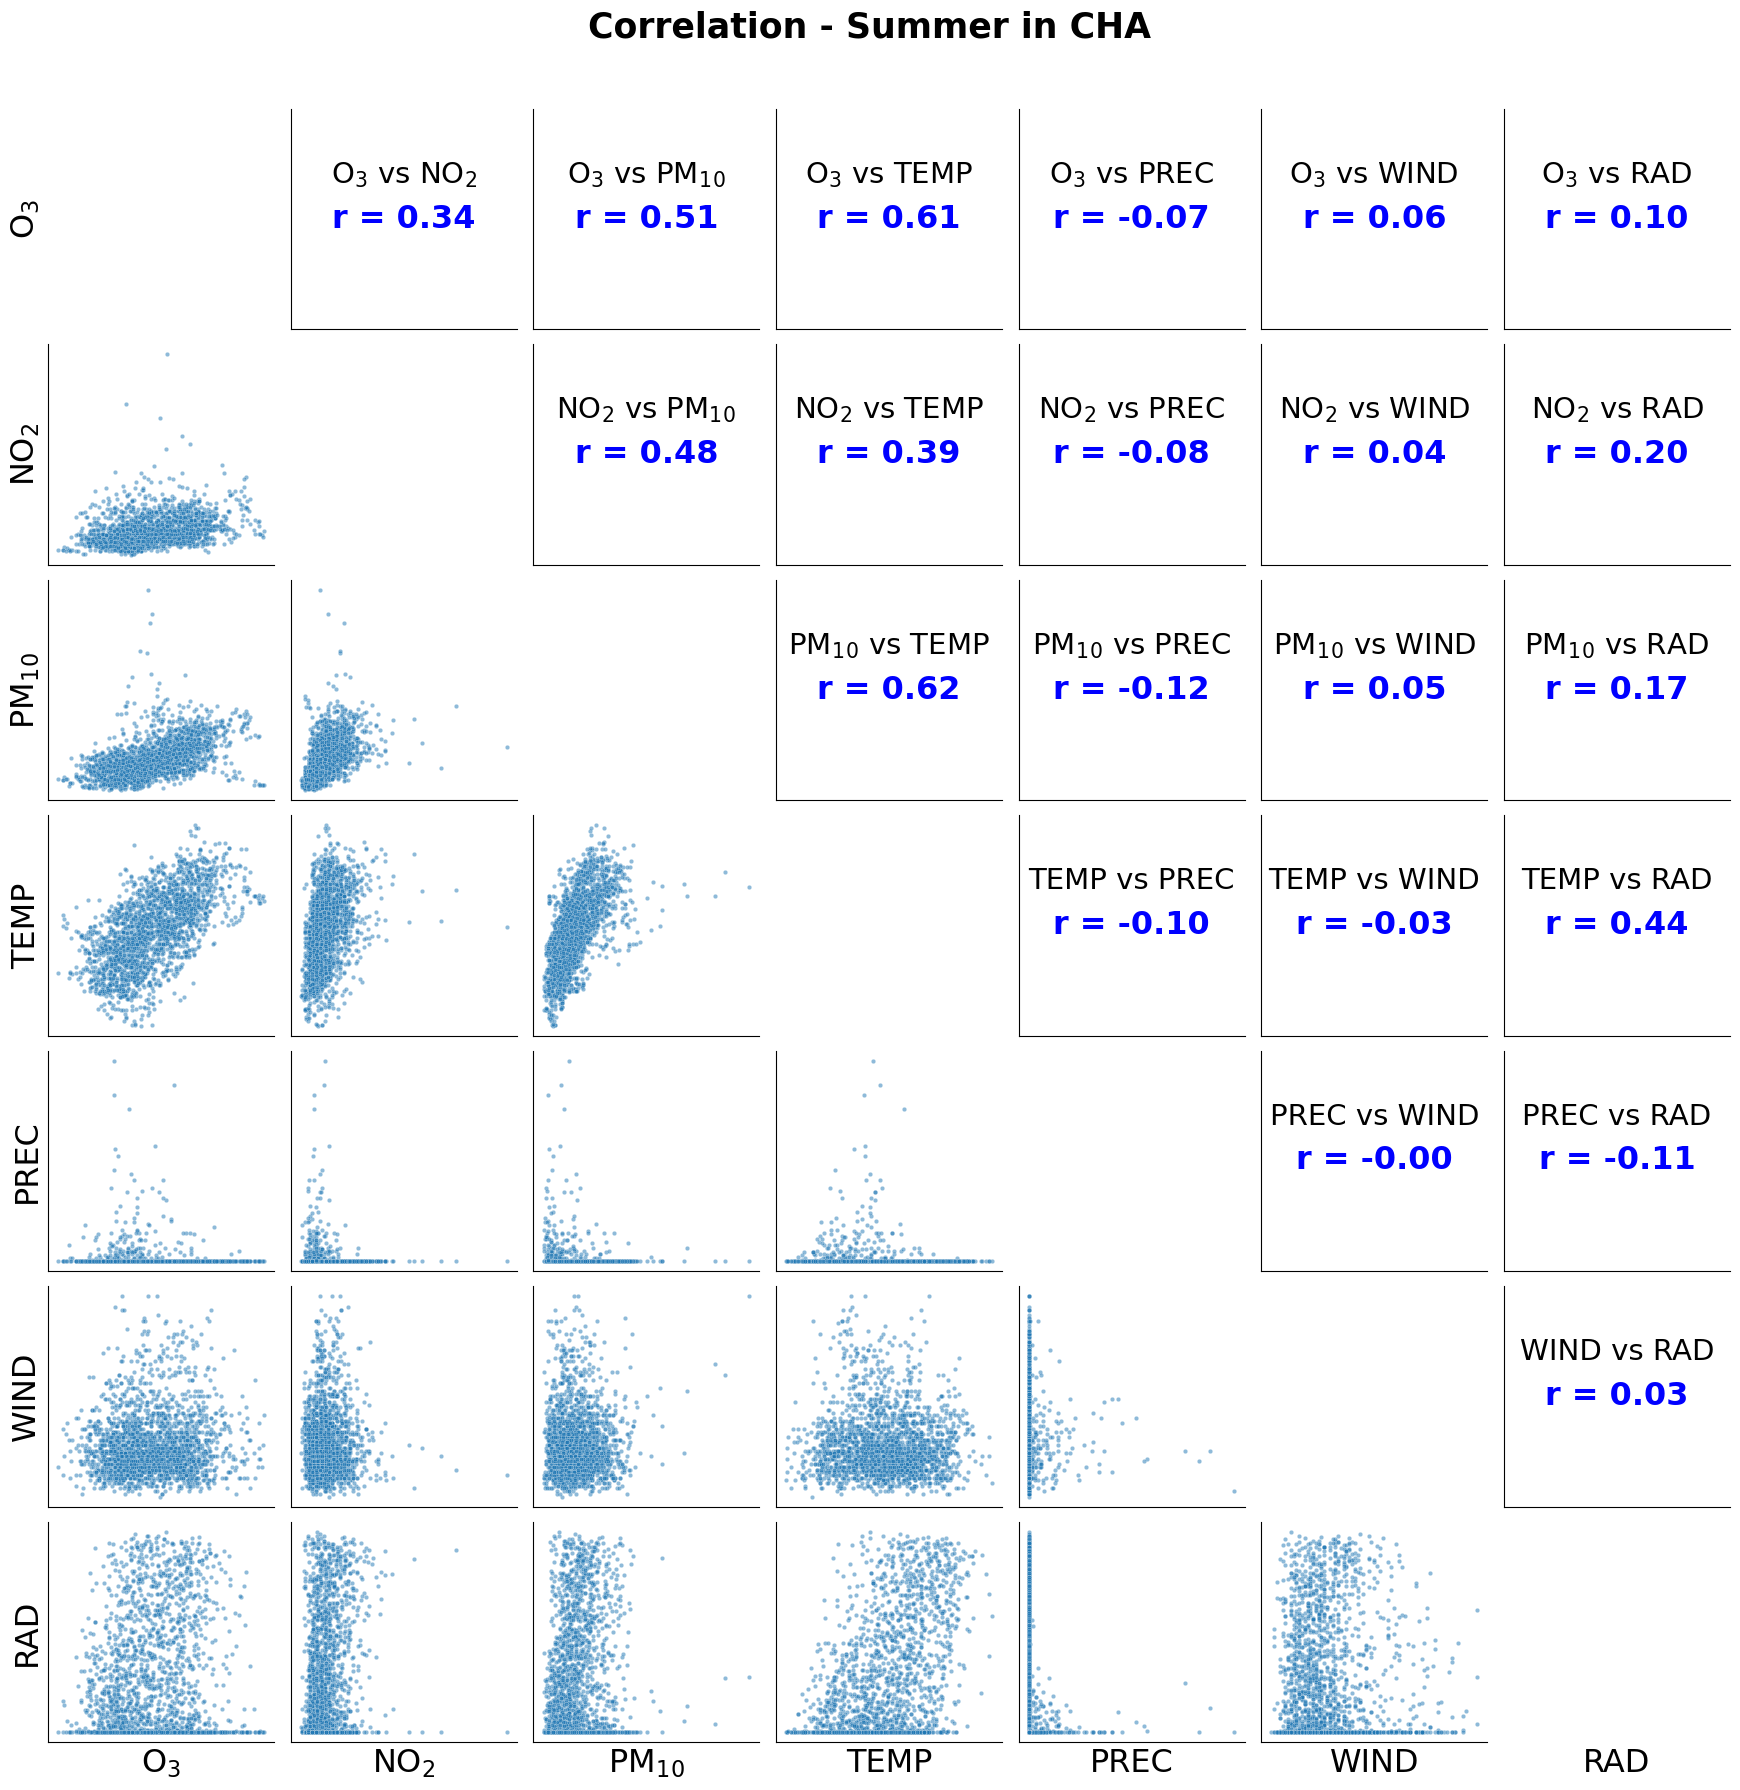

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


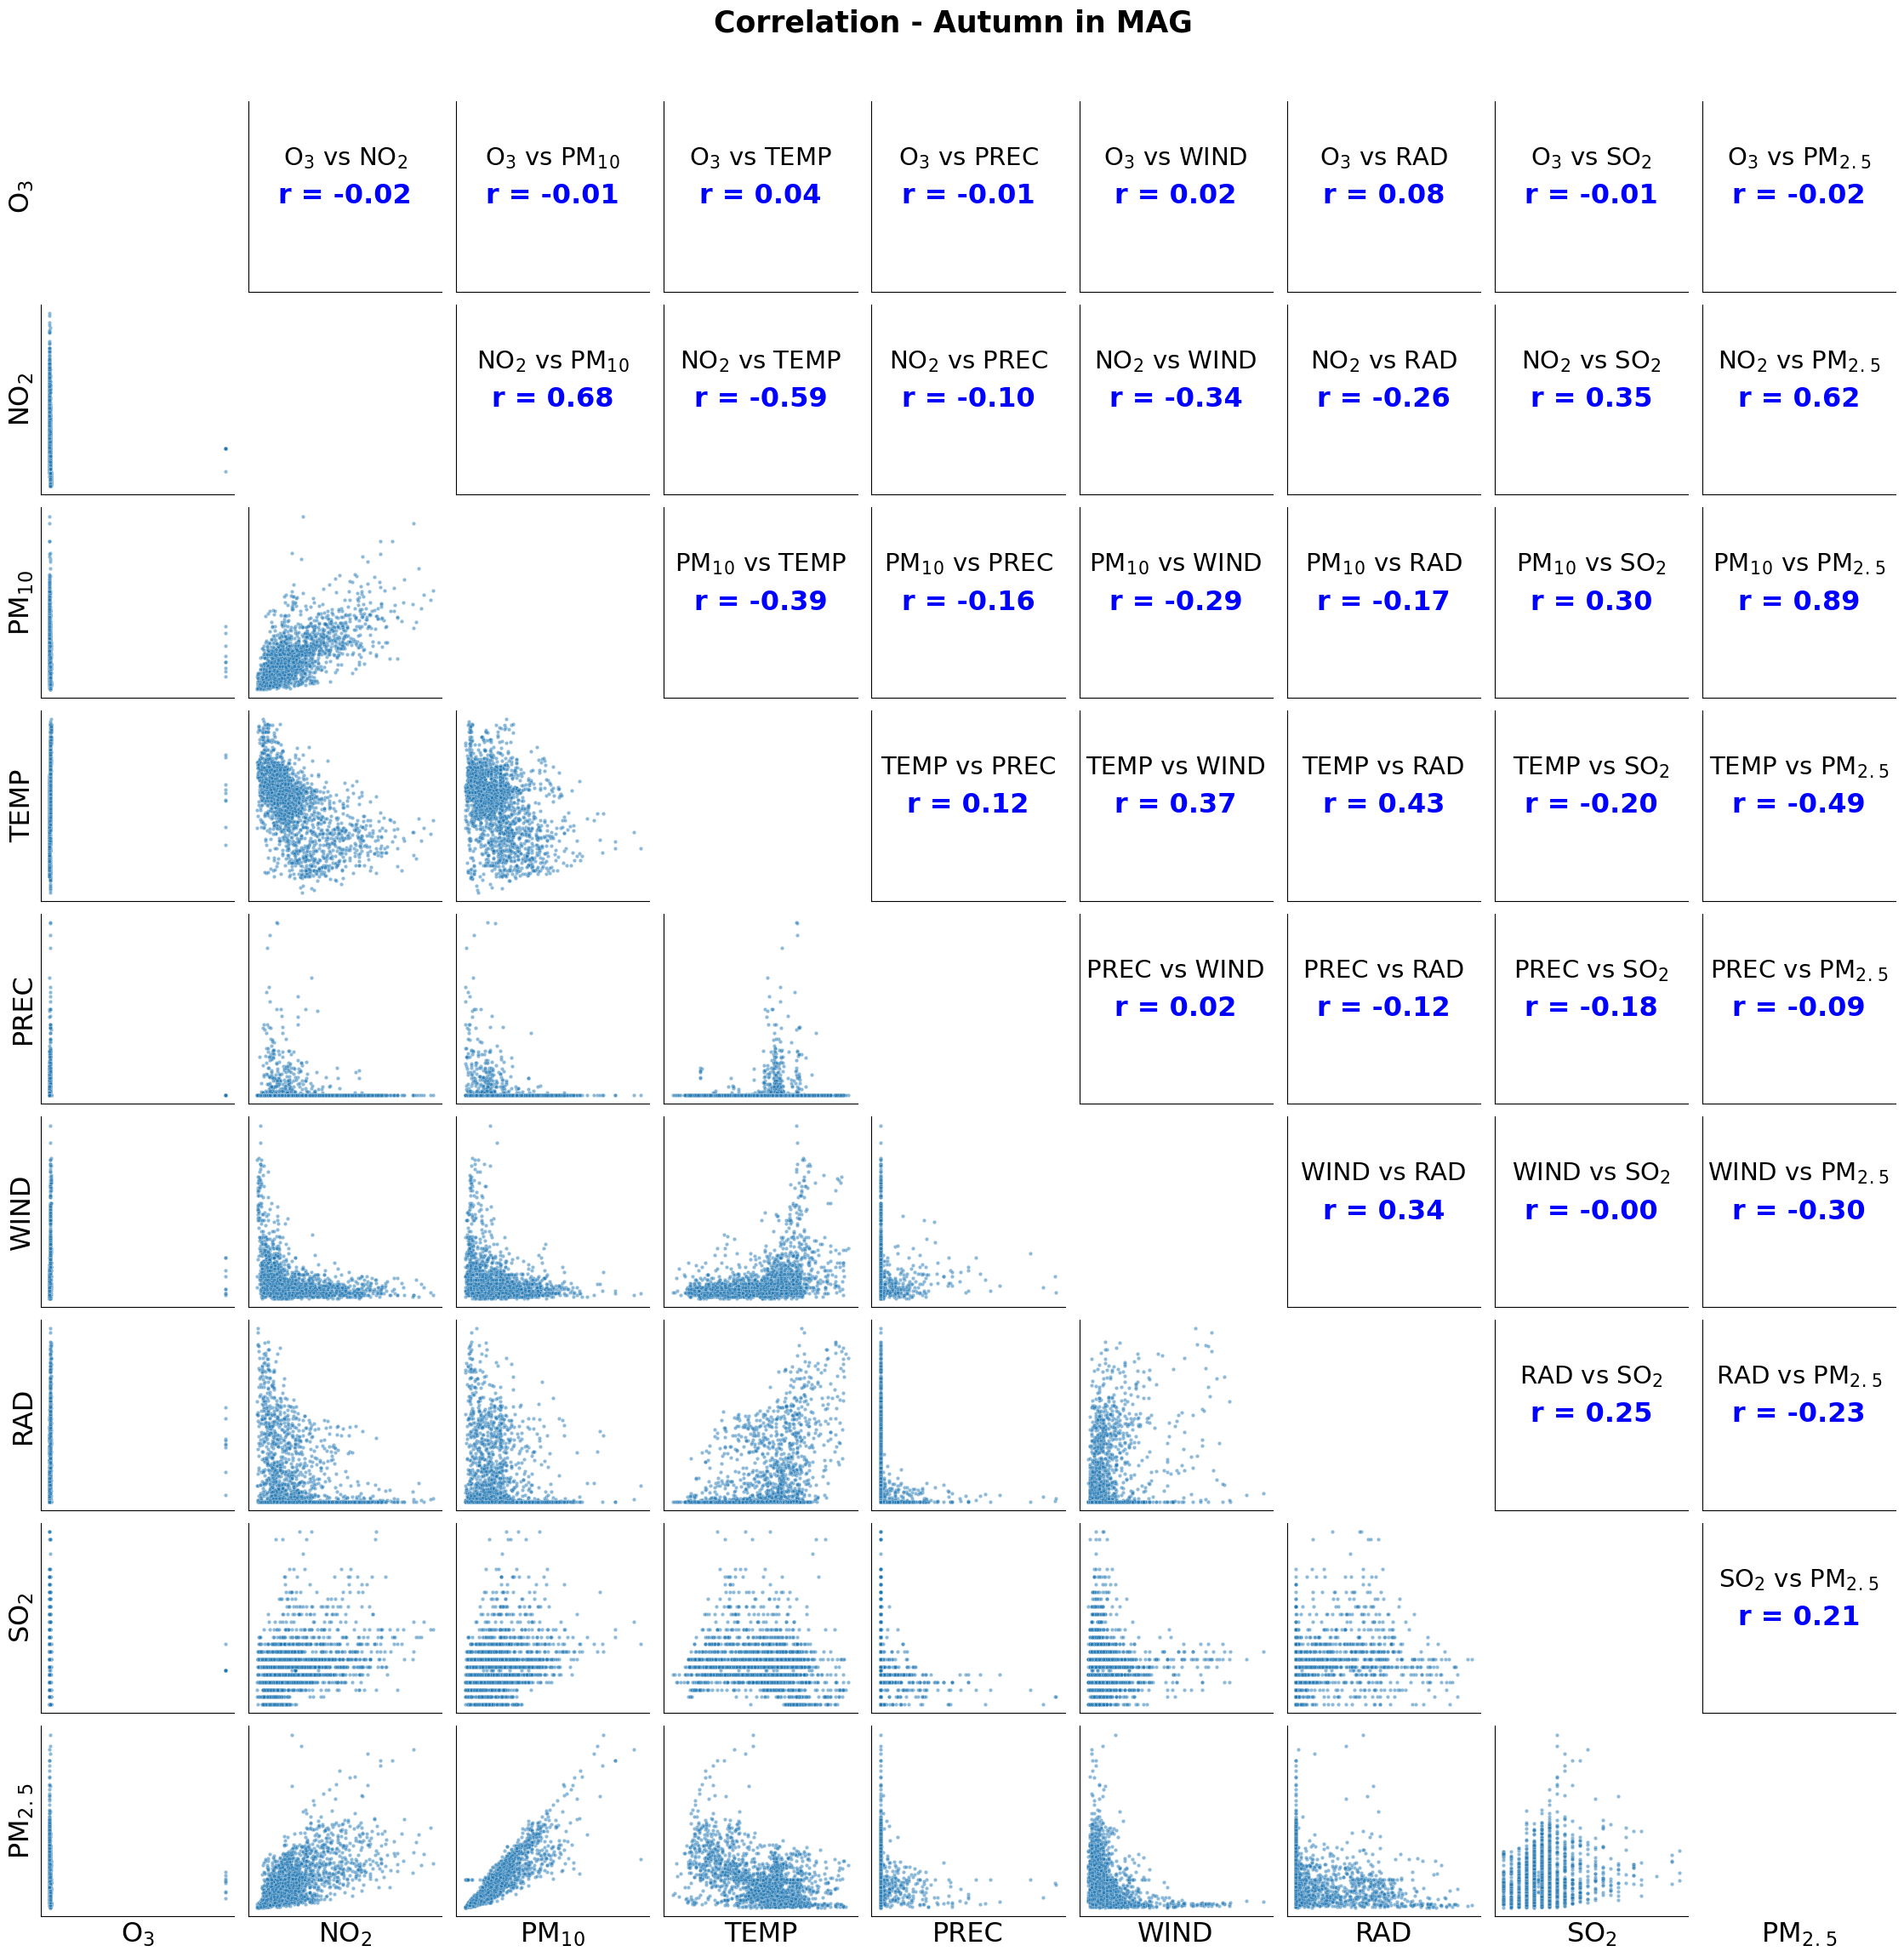

C:\Users\alexa\AppData\Local\Temp\ipykernel_28328\2343759730.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


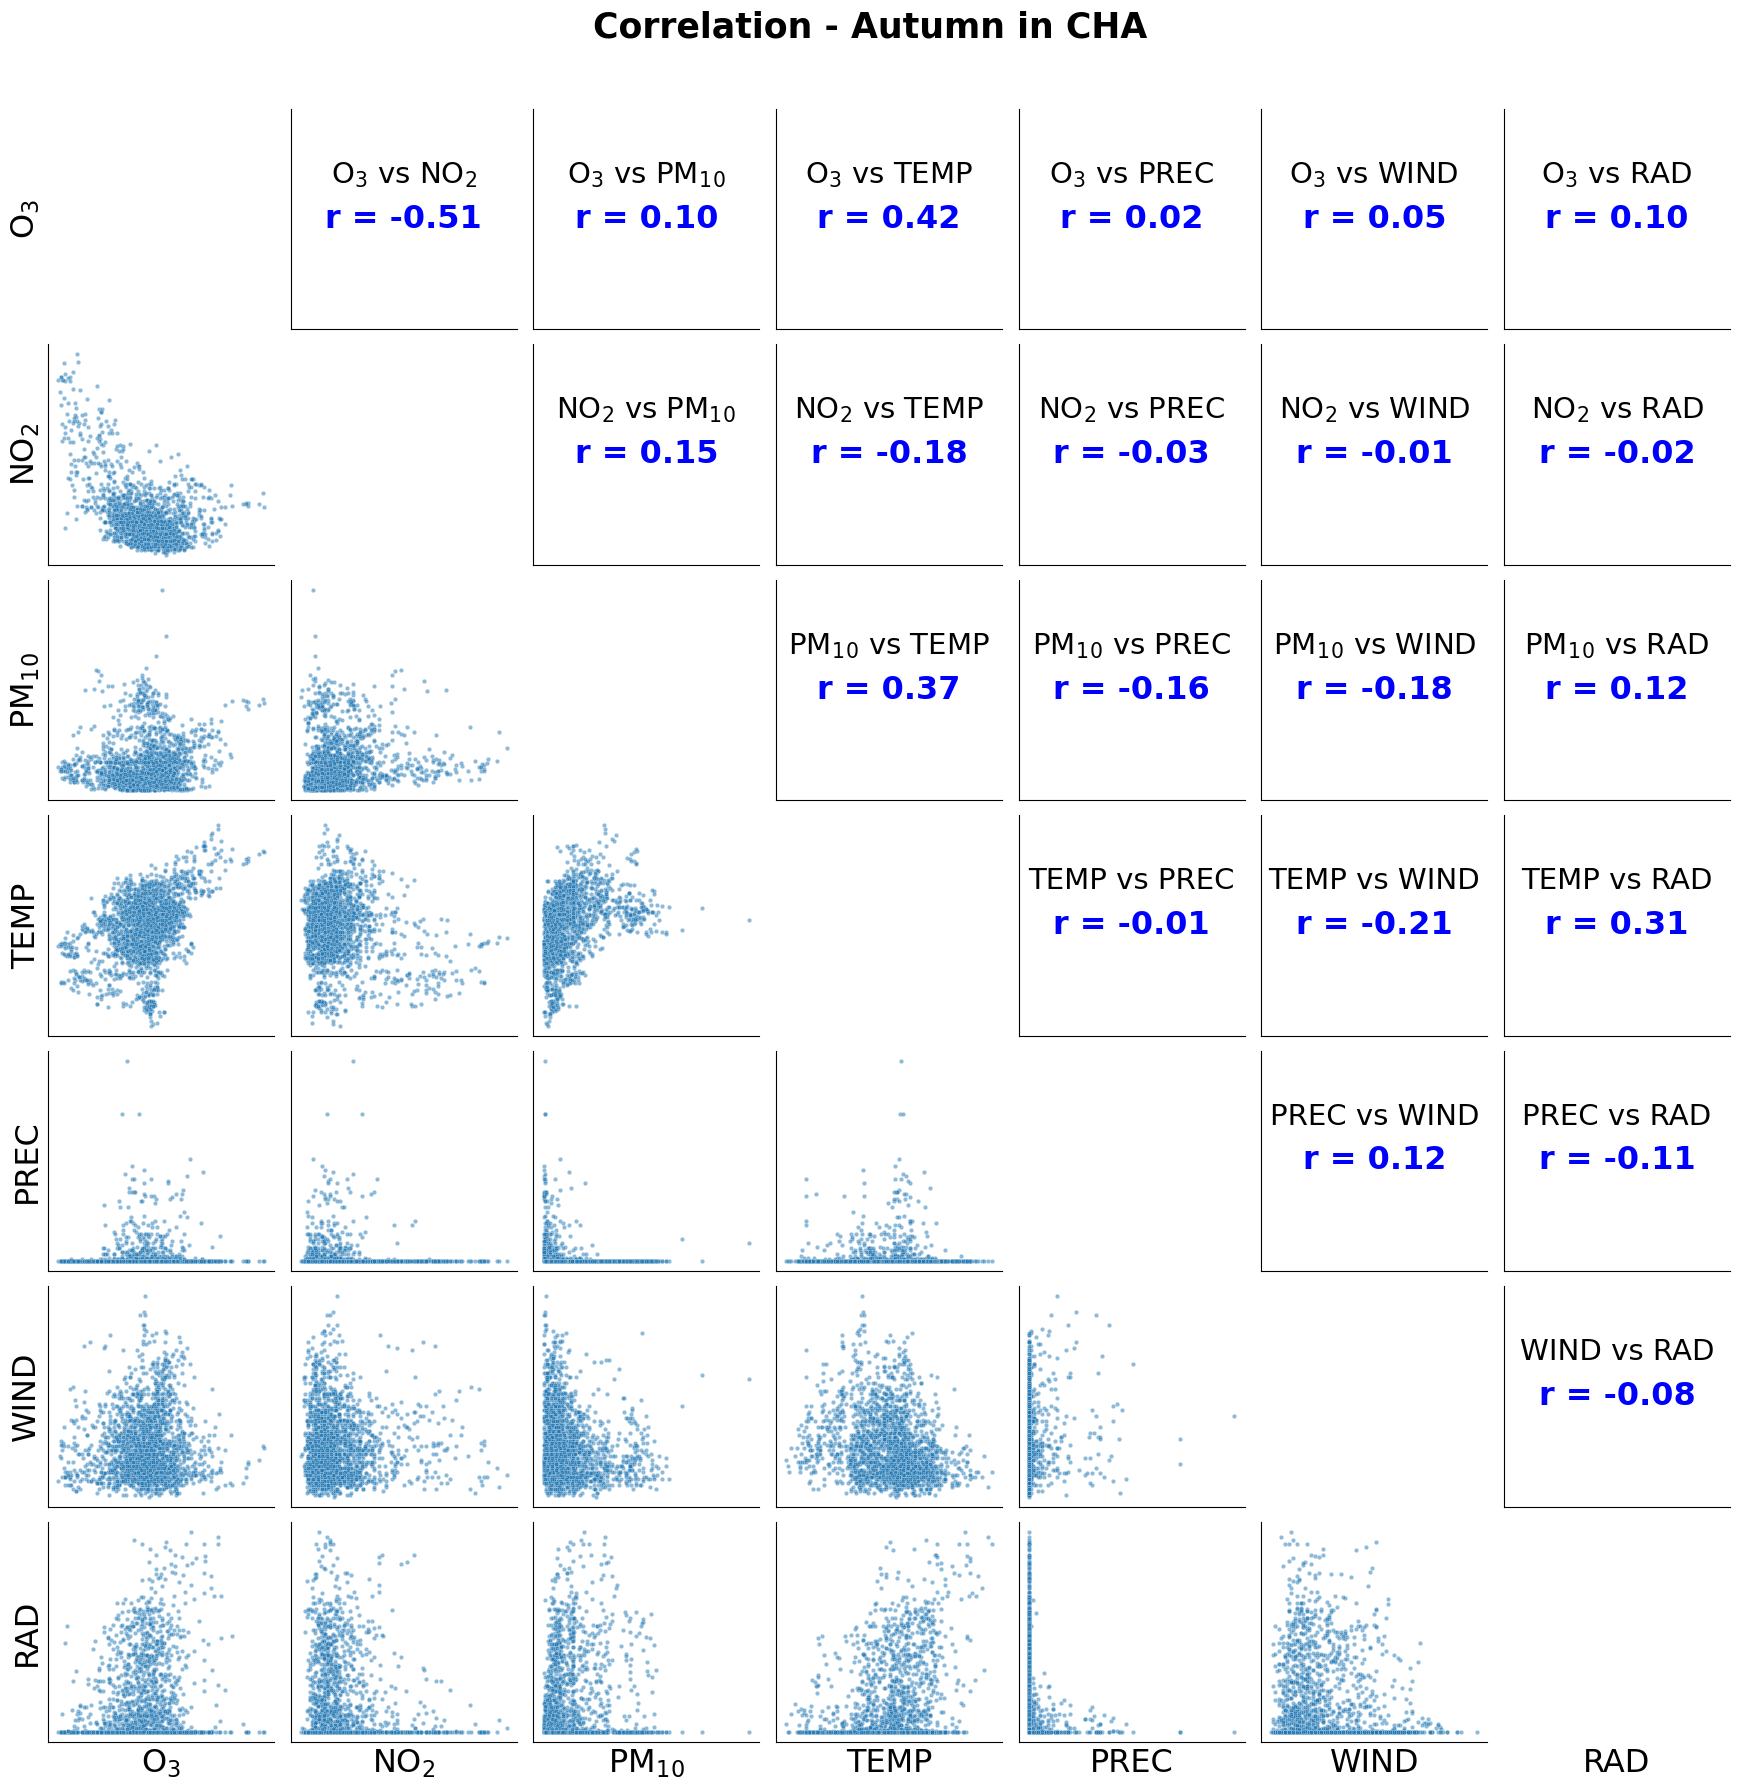

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

# ==== CONFIG ====
csv_folder = ""  # <-- Set this to the path with your CSV files
variables = ["O$_3$", "NO$_2$", "PM$_1$$_0$", "TEMP", "PREC", "WIND", "RAD", "SO$_2$", "PM$_2$$_.$$_5$"]

# ==== 1. Load and Split MAG / CHA Data ====
mag_data = pd.DataFrame()
cha_data = pd.DataFrame()
datetime_col = None

mag_data = pd.DataFrame()
cha_data = pd.DataFrame()
datetime_col = None

for var in variables:
    file_path = os.path.join(csv_folder, f"{var}.csv")
    df = pd.read_csv(file_path, sep=';', encoding='utf-8')

    mag_col = [col for col in df.columns if "Magadino-Cadenazzo" in col][0]

    if datetime_col is None:
        datetime_col = pd.to_datetime(df.iloc[:, 0], format="%d.%m.%Y %H:%M")

    mag_data[var] = df[mag_col].values

    # Check for Chaumont data
    cha_cols = [col for col in df.columns if "Chaumont" in col]
    if cha_cols:
        cha_data[var] = df[cha_cols[0]].values
    else:
        cha_data[var] = [0] * len(df)  # <-- Fill missing Chaumont data with 0s

# Add datetime column
mag_data['datetime'] = datetime_col
cha_data['datetime'] = datetime_col

mag_data.fillna(mag_data.mean(numeric_only=True), inplace=True)
cha_data.fillna(cha_data.mean(numeric_only=True), inplace=True)

# ==== 2. Add Season Column ====
def get_season(dt):
    if dt.month in [12, 1, 2]:
        return "Winter"
    elif dt.month in [3, 4, 5]:
        return "Spring"
    elif dt.month in [6, 7, 8]:
        return "Summer"
    elif dt.month in [9, 10, 11]:
        return "Autumn"

mag_data['season'] = mag_data['datetime'].apply(get_season)
cha_data['season'] = cha_data['datetime'].apply(get_season)

# ==== 3. Plotting Function ====
def correlation_plot(df, season, label):
    subset = df[df['season'] == season].drop(columns=['datetime', 'season'])

    if subset.empty:
        print(f"No data for {label} - {season}")
        return

    numeric_subset = subset.select_dtypes(include=np.number)

    # Filter out variables with only zeros
    non_zero_cols = [col for col in numeric_subset.columns if not np.all(numeric_subset[col] == 0)]
    numeric_subset = numeric_subset[non_zero_cols]

    if numeric_subset.shape[1] < 2:
        print(f"Not enough valid variables to plot for {label} - {season}")
        return

    # Define correlation function
    def corrfunc(x, y, **kws):
        r, _ = pearsonr(x, y)
        ax = plt.gca()
        ax.text(0.5, 0.5, f"r = {r:.2f}", fontsize=23, fontweight='bold', color='blue',
                ha='center', va='center', transform=ax.transAxes)

    # Create PairGrid only with valid columns
    g = sns.PairGrid(numeric_subset)

    g.map_lower(sns.scatterplot, s=10, alpha=0.5)
    g.map_upper(corrfunc)

    # Clean diagonal
    for i in range(len(numeric_subset.columns)):
        ax = g.axes[i, i]
        ax.set_facecolor("white")
        ax.tick_params(left=False, bottom=False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # Annotate upper triangle
    for i in range(len(numeric_subset.columns)):
        for j in range(i + 1, len(numeric_subset.columns)):
            ax = g.axes[i, j]
            ax.text(0.5, 0.7, f"{numeric_subset.columns[i]} vs {numeric_subset.columns[j]}",
                    fontsize=21, ha='center', va='center', color='black', transform=ax.transAxes)

    # Increase tick label font sizes
    for i in range(len(numeric_subset.columns)):
        for j in range(len(numeric_subset.columns)):
            ax = g.axes[i, j]
            ax.tick_params(labelsize=22)

    # Axis labels font size
    for ax in g.axes[-1, :]:
        ax.set_xlabel(ax.get_xlabel(), fontsize=23)
    for ax in g.axes[:, 0]:
        ax.set_ylabel(ax.get_ylabel(), fontsize=23)

    g.figure.suptitle(f"Correlation - {season} in {label}",
                   y=1.02, fontsize=25, fontweight='bold')
                   

    plt.tight_layout()
    plt.show()

# ==== 4. Plot Correlation for Each Season & Group ====
for s in ['Winter', 'Spring', 'Summer', 'Autumn']:
    correlation_plot(mag_data, s, "MAG")
    correlation_plot(cha_data, s, "CHA")

